# **License Plate Recognition using YOLO and trOCR**

# **1. Installing Required Packages**

In [1]:
!pip install ultralytics
!pip install evaluate
!pip install transformers
!pip install sentencepiece
!pip install jiwer
!pip install datasets
!pip install -q -U accelerate
!pip install protobuf
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but y

**Setting up paths of images and labels**

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

train_detection = '/kaggle/input/license-plate-recognition-soul-page/Licplatesdetection_train/license_plates_detection_train/'
train_recognition = '/kaggle/input/license-plate-recognition-soul-page/Licplatesrecognition_train/license_plates_recognition_train/'
detect_csv = '/kaggle/input/license-plate-recognition-soul-page/Licplatesdetection_train.csv'
recog_csv = '/kaggle/input/license-plate-recognition-soul-page/Licplatesrecognition_train.csv'
test = '/kaggle/input/license-plate-recognition-soul-page/test/test/test/'
sample_submission = '/kaggle/input/license-plate-recognition-soul-page/SampleSubmission.csv'

# **2. Training Yolo11 Model to identify License Plates**

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import shutil
from ultralytics import YOLO
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Creating a Yolo Supported Dataset From given images and labels

In [4]:
# copy the training images from detection folder to Yolo Dataset Folder
try:
    shutil.copytree(train_detection, 'Yolo/images/train/')
    shutil.copytree(train_detection, 'Yolo/images/val/')
except FileExistsError:
    print(f"images directory already exist.")
except Exception as e:
    print(f"An error occurred: {e}")

# Create Folder for Labels
try:
    os.makedirs('Yolo/labels/train')
    os.makedirs('Yolo/labels/val')
except FileExistsError:
    print(f"labels directory already exist.")
except Exception as e:
    print(f"An error occurred: {e}")

# Creating Custom dataset.yaml configuration File
dataset = os.path.abspath("Yolo")
with open('Yolo/dataset.yaml','w') as file:
    file.writelines(
        [f'path: {dataset}\n',
        'train: images/train\n',
        'val: images/val\n',
        'test:\n\n',
        'names:\n',
        '   0: LicensePlate\n',
        ]
)

# Converting given Coordinates from *Licplatesdetection_train.csv* to Yolo Supported Annotations

In [5]:
def create_yolo_lables(col):
    img = cv2.imread(f'Yolo/images/train/{col[0]}')
    image_height, image_width = img.shape[:2]
    x_center = ((col[2] + col[4]) / 2) / image_width
    y_center = ((col[1] + col[3]) / 2) / image_height
    box_width = (col[4] - col[2]) / image_width
    box_height = (col[3] - col[1]) / image_height
    bbox = f"{x_center} {y_center} {box_width} {box_height}"
    file_name = col[0].split('.')[0]+'.txt'
    with open('Yolo/labels/train/'+ file_name, "w") as file:
            file.write("0 " + bbox + "\n")
    with open('Yolo/labels/val/'+ file_name, "w") as file:
            file.write("0 " + bbox + "\n")
def convert_csv_to_yolo():
    annotation_file = pd.read_csv(detect_csv)
    annotation_file.apply(create_yolo_lables,axis = 1)
    
convert_csv_to_yolo()

# Training the Yolo11m Model 

In [6]:
YoloModel = YOLO('Yolo/yolo11m.pt')
train_res = YoloModel.train(
    data = 'Yolo/dataset.yaml',
    epochs = 20,
    device = device
)

100%|██████████| 38.8M/38.8M [00:00<00:00, 217MB/s]


Ultralytics 8.3.152 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Yolo/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=Yolo/yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=

100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]
2025-06-09 10:44:00,061	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-09 10:44:00,692	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2197.8±534.7 MB/s, size: 105.6 KB)


train: Scanning /kaggle/working/Yolo/labels/train... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<00:00, 1157.32it/s]

train: New cache created: /kaggle/working/Yolo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 1003.1±489.1 MB/s, size: 117.2 KB)


val: Scanning /kaggle/working/Yolo/labels/val... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:01<00:00, 803.86it/s]


val: New cache created: /kaggle/working/Yolo/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.96G      1.324      1.614      1.172         11        640: 100%|██████████| 57/57 [00:31<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.64it/s]


                   all        900        900      0.896      0.836       0.92      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.04G      1.328     0.9929      1.131          9        640: 100%|██████████| 57/57 [00:31<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


                   all        900        900      0.339      0.376      0.213      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.09G      1.339      1.329       1.15          9        640: 100%|██████████| 57/57 [00:33<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.77it/s]

                   all        900        900      0.571      0.684      0.616      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.09G      1.315     0.9347       1.14          6        640: 100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.82it/s]


                   all        900        900      0.887      0.907      0.943      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.07G      1.244     0.8564      1.132          9        640: 100%|██████████| 57/57 [00:32<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]

                   all        900        900      0.893      0.887      0.935      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.06G      1.165     0.7804      1.071          9        640: 100%|██████████| 57/57 [00:32<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.84it/s]

                   all        900        900      0.932      0.901      0.971      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.02G      1.155     0.7568      1.076          5        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]

                   all        900        900      0.899      0.934      0.957      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.09G      1.104      0.731       1.03          8        640: 100%|██████████| 57/57 [00:32<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.84it/s]

                   all        900        900      0.941      0.924      0.979      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.06G      1.073     0.6628      1.025          6        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.87it/s]

                   all        900        900      0.962      0.926      0.986      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.06G      1.011     0.6143          1         10        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.86it/s]

                   all        900        900      0.955      0.971       0.99      0.723


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.02G      1.008     0.6034     0.9905          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.86it/s]

                   all        900        900      0.973      0.953      0.991      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.09G          1     0.5869      1.008          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.84it/s]

                   all        900        900      0.972      0.943      0.991      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.07G     0.9453     0.5679     0.9808          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.87it/s]

                   all        900        900      0.965      0.979      0.992      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.06G     0.9575     0.5578     0.9747          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.85it/s]

                   all        900        900      0.976      0.984      0.994      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.02G     0.9308     0.5194      0.965          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.87it/s]

                   all        900        900      0.975      0.987      0.994      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.09G     0.8885     0.5082     0.9621          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.86it/s]

                   all        900        900      0.989      0.987      0.995      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.06G     0.8675     0.4775     0.9396          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.86it/s]

                   all        900        900      0.988      0.994      0.995      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.11G     0.8529      0.467     0.9307          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.87it/s]

                   all        900        900      0.993      0.989      0.995      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.03G     0.8301     0.4355     0.9202          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.87it/s]

                   all        900        900      0.996      0.996      0.995      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.08G     0.8127     0.4274     0.9139          4        640: 100%|██████████| 57/57 [00:32<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.87it/s]

                   all        900        900      0.993      0.999      0.995      0.799



20 epochs completed in 0.244 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.76it/s]


                   all        900        900      0.996      0.996      0.995      0.809
Speed: 0.1ms preprocess, 8.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


**Downloading Trained Yolo Model to Detect Numberplates**</br>
Click here to <a href = 'runs/detect/train/weights/best.pt'> Download </a> best.pt 

# Predictions Based on Yolo 


0: 640x416 1 LicensePlate, 46.0ms
Speed: 1.7ms preprocess, 46.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 384x640 1 LicensePlate, 46.9ms
Speed: 2.0ms preprocess, 46.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 1 LicensePlate, 45.0ms
Speed: 2.3ms preprocess, 45.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 1 LicensePlate, 48.6ms
Speed: 2.5ms preprocess, 48.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 LicensePlate, 44.0ms
Speed: 1.7ms preprocess, 44.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 LicensePlate, 19.4ms
Speed: 1.8ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 LicensePlate, 18.7ms
Speed: 2.4ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 LicensePlate, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference

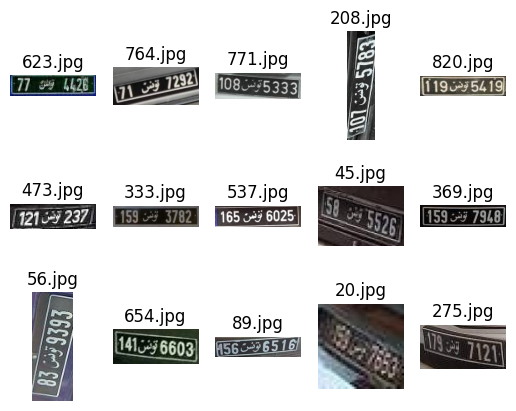

In [7]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
path = train_detection
i = 0
for img in os.listdir(path):
    if i <15:
        plt.subplot(3, 5, i+1)
        image = cv2.imread(path+img)
        result = model.predict(image)
        for r in result:
            boxes = r.boxes
            for box in boxes:
                x, y, w, h = box.xyxy[0]
        licPlate = image[int(y):int(h), int(x):int(w)]  
        
        plt.imshow(licPlate)
        plt.axis('off')
        plt.title(img)
        i+=1
    else:
        break 

# **3. Fine-Tuning trOCR to Given Dataset**

In [8]:
import torch
import evaluate
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
 
from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

#  Setting up Random Seed to 42

In [9]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [10]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 32
    EPOCHS:        int = 20
    LEARNING_RATE: float = 0.00005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = train_recognition
        
@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-stage1'


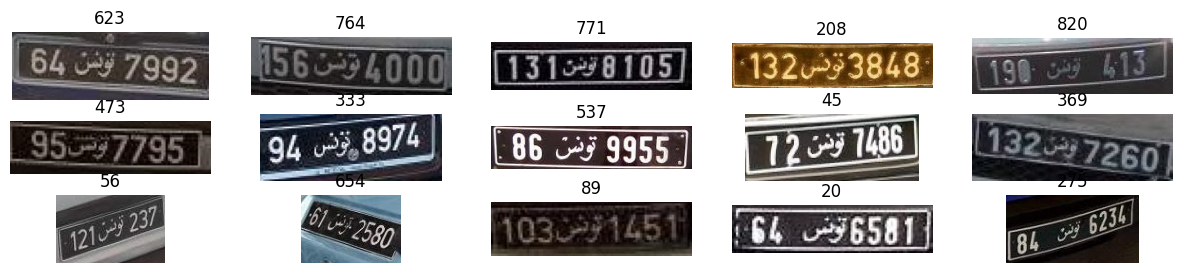

In [11]:
def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        all_images = os.listdir(dataset_path)
        image = plt.imread(dataset_path+all_images[i])
        plt.imshow(image)
        plt.axis('off')
        plt.title(all_images[i].split('.')[0])
    plt.show()
 
 
visualize(DatasetConfig.DATA_ROOT)

**Splitting the dataset into train and test**

In [12]:
train_df = pd.read_csv(recog_csv)
test_df = train_df.iloc[700:].reset_index(drop=True)
train_df = train_df.iloc[:700]
train_df,test_df

(      img_id      text
 0      0.jpg  117T3989
 1      1.jpg  128T8086
 2     10.jpg   94T3458
 3    100.jpg  133T6719
 4    101.jpg   68T5979
 ..       ...       ...
 695  732.jpg   89T4187
 696  733.jpg  130T2637
 697  735.jpg  141T6603
 698  736.jpg   90T9848
 699  737.jpg  119T6926
 
 [700 rows x 2 columns],
       img_id      text
 0    738.jpg   131T954
 1    739.jpg  103T1451
 2     74.jpg  139T8869
 3    740.jpg  191T1006
 4    741.jpg  135T5906
 ..       ...       ...
 195   95.jpg   39T8707
 196   96.jpg    92T589
 197   97.jpg   180T706
 198   98.jpg   87T7369
 199   99.jpg  159T8894
 
 [200 rows x 2 columns])

In [13]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

# Using the Custom Dataset for Fine Tuning

In [14]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=10):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
 
 
    def __len__(self):
        return len(self.df)
 
 
    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['img_id'][idx]
        # The text (label).
        text = self.df['text'][idx]
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

# Creating a Train and Validation Dataset for OCR

In [15]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)

train_dataset = CustomOCRDataset(
    root_dir=os.path.join(train_recognition),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(train_recognition),
    df=test_df,
    processor=processor
)

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

# Loading Pretrained *trOCR-small-stage1* Model

In [16]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['enco

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [17]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
 

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [18]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [19]:
cer_metric = evaluate.load('cer')
 

def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
 
 
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
 
 
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
 
 
    return {"cer": cer}

In [20]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

In [21]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

# Training the OCR Model on our Custom Dataset / FineTuning

In [22]:
res = trainer.train()

Epoch,Training Loss,Validation Loss,Cer
1,5.175300,1.868462,0.369737
2,1.409500,1.245005,0.218421
3,0.963000,0.863734,0.163816
4,0.725300,0.583249,0.103947
5,0.467600,0.427726,0.093421
6,0.350900,0.484741,0.109211
7,0.291000,0.445176,0.098684
8,0.230800,0.410767,0.089474
9,0.219800,0.369434,0.078289
10,0.170800,0.331917,0.067763


In [23]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model_path = 'seq2seq_model_printed/checkpoint-'+str(res.global_step)
ocr_model = VisionEncoderDecoderModel.from_pretrained(trained_model_path).to(device)

# Accuracy on training Dataset

In [24]:
def accuracy(dataset_path):
    data = pd.read_csv(dataset_path)
    c = 0
    for i in range(len(data[:])):
        image = Image.open(train_recognition+data['img_id'][i]).convert('RGB')
        pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
        generated_ids = ocr_model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        if generated_text == data['text'][i]:
            c+=1
    return c/len(data[:])
        
accuracy(recog_csv)

0.9588888888888889

# Looking at Few Predictions From Train Dataset

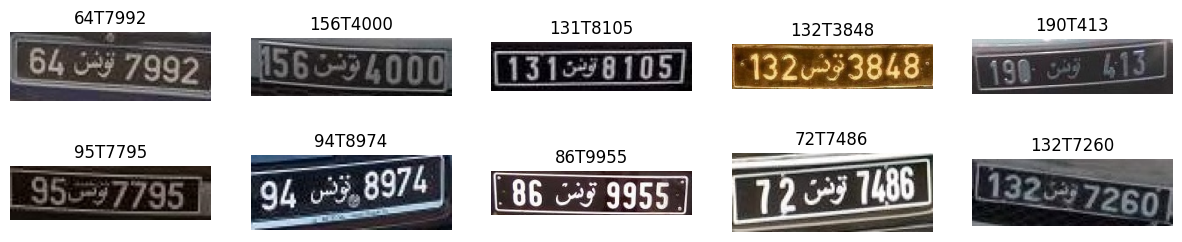

In [25]:
def test_inference(dataset_path):
    plt.figure(figsize=(15, 3))
    all_images = os.listdir(dataset_path)
    for i in range(10):
        plt.subplot(2, 5, i+1)
        image = Image.open(dataset_path+all_images[i]).convert('RGB')
        pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
        generated_ids = ocr_model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        plt.imshow(image)
        plt.axis('off')
        plt.title(generated_text)
    plt.show()
 
 
test_inference(DatasetConfig.DATA_ROOT)

# **4. Combining Both Models to Detect and Recognise License Plate**

**Viszualizing Few Predictions from *Test Dataset***


0: 640x480 1 LicensePlate, 56.3ms
Speed: 2.3ms preprocess, 56.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 LicensePlate, 50.7ms
Speed: 3.0ms preprocess, 50.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 LicensePlate, 47.2ms
Speed: 1.8ms preprocess, 47.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 LicensePlate, 21.2ms
Speed: 2.4ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 LicensePlate, 19.4ms
Speed: 1.7ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 LicensePlate, 46.4ms
Speed: 2.1ms preprocess, 46.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 1 LicensePlate, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 LicensePlate, 47.8ms
Speed: 1.9ms preprocess, 47.8ms inference

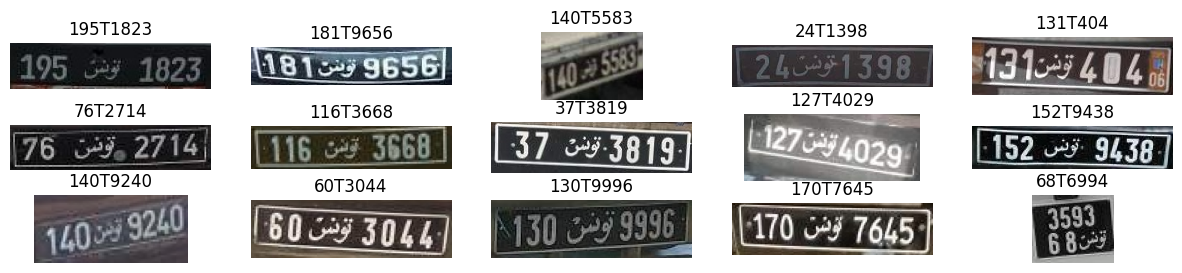

In [26]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
path = test
i = 0
plt.figure(figsize=(15, 3))
for img in os.listdir(path):
    if i <15:
        plt.subplot(3, 5, i+1)
        image = cv2.imread(path+img)
        #print(image)
        result = model.predict(image)
        for r in result:
            boxes = r.boxes
            for box in boxes:
                x, y, w, h = box.xyxy[0]
        licPlate = image[int(y):int(h), int(x):int(w)]  
        
        pixel_values = processor(Image.fromarray(licPlate).convert('RGB'), return_tensors='pt').pixel_values.to(device)
        generated_ids = ocr_model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        plt.imshow(licPlate)
        plt.axis('off')
        plt.title(generated_text)
        i+=1
    else:
        break

# **5. Predictions and Saving Results into *Submission.csv* !**

In [27]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
path = test

submission = pd.read_csv(sample_submission).set_index('id')
submission.fillna(0,inplace = True)

#submission.loc['img_901_1']['0'] = 1
# print(submission)
for img in os.listdir(path):
    
    filename = img.split('.')[0]
    image = cv2.imread(path+img)
    
    print(img)
    result = model.predict(image)
    for r in result:
        boxes = r.boxes
        for box in boxes:
            x, y, w, h = box.xyxy[0]
    licPlate = image[int(y):int(h), int(x):int(w)]  

    pixel_values = processor(Image.fromarray(licPlate).convert('RGB'), return_tensors='pt').pixel_values.to(device)
    generated_ids = ocr_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # The License Plate Number is divide into two parts left and right 
    # Since the length of Number is 7 the right part is 4 digits and left part is 3 digits
    # Both Left and Right are Right Justified to 3 and 4 digits Respectively with 0 as Fill Char
    print(generated_text)
    left,right,*_ = generated_text.split('T')
    left = left.rjust(3,'0')
    right = right.rjust(4,'0')
    print(left,right)
    number = left+right
    for i in range(7):
        submission.loc[f'img_{filename}_{i+1}'][number[i]] = 1
submission.to_csv('submission.csv')
print('Result Saved')
    

1075.jpg

0: 640x480 1 LicensePlate, 19.2ms
Speed: 1.9ms preprocess, 19.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
195T1823
195 1823
1031.jpg

0: 480x640 1 LicensePlate, 19.8ms
Speed: 2.1ms preprocess, 19.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
181T9656
181 9656
1024.jpg

0: 384x640 1 LicensePlate, 17.2ms
Speed: 1.8ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
140T5583
140 5583
1009.jpg

0: 384x640 1 LicensePlate, 16.2ms
Speed: 1.7ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
24T1398
024 1398
915.jpg

0: 384x640 1 LicensePlate, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
131T404
131 0404
1055.jpg

0: 640x384 1 LicensePlate, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)
76T2714
076 2714
1026.jpg

0: 640x480 1 LicensePlate, 18.5ms
Speed:

Submission File<a href = 'submission.csv'> Download </a>